In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms
from miniai.imports import *
from miniai.datasets import *

/home/galvanized_heart/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"GPU is there" if torch.cuda.is_available() else Exception("GPU is missing") 

'GPU is there'

### Import Data

In [12]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name).remove_columns(yl)

# From ../03_collate_CLIP.ipynb
@inplace
def transformi(b): 
    b[xl] = [TF.to_tensor(o) for o in b[xl]]

def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

c_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
c_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

"""# Modified noisify() to process CLIP embs
def noisify(x0):
    device = x0.device
    with torch.no_grad():
        x = clip_pro(images=x0, return_tensors="pt", do_rescale=False).to(device)
        c = clip_model.get_image_features(x["pixel_values"])
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device), c), ε
    
def collate_sd(b): return noisify(default_collate(b)[xl])"""

def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b):
    #import pdb; pdb.set_trace()    
    b = default_collate(b)
    #(xt,t),eps = noisify(b[xl])       # original line from Jeremy
    
    # ok, let's do the padding and shifting the range from (0,1) to (-0.5,0.5) for SD
    b_padded_n_shifted = F.pad(b[xl], (2,2,2,2))-0.5
    (xt,t),eps = noisify(b_padded_n_shifted)
    
    # Below are lines for CLIP
    inputs = c_processor(images=b[xl], return_tensors="pt", padding=True, do_rescale=False).to("cuda")
    image_input = inputs["pixel_values"]
    with torch.no_grad():
        image_features = c_model.get_image_features(image_input)
    return (xt,t,image_features),eps

def dl_sd(ds): 
    return DataLoader(ds, batch_size=16, collate_fn=collate_ddpm, num_workers=0)

tdsd = dsd.with_transform(transformi)
dls = DataLoaders(dl_sd(tdsd['train']), dl_sd(tdsd['valid']))

In [13]:
dl = dls.train
b = next(iter(dl))

### Build Conditional UNet Model

In [34]:
def timestep_embedding(tsteps, emb_dim, max_period=10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

def saved(m, blk):
    m_ = m.forward
    @wraps(m.forward)
    def _f(*args, **kwargs):
        res = m_(*args, **kwargs)
        blk.saved.append(res)
        return res
    m.forward = _f
    return m

def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers

def pre_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

def heads_to_batch(x, heads):
    n,sl,d = x.shape
    x = x.reshape(n, sl, heads, -1)
    return x.transpose(2, 1).reshape(n*heads,sl,-1)

def batch_to_heads(x, heads):
    n,sl,d = x.shape
    x = x.reshape(-1, heads, sl, d)
    return x.transpose(2, 1).reshape(-1,sl,d*heads)

class SelfAttention(nn.Module):
    def __init__(self, ni, attn_chans, transpose=True):
        super().__init__()
        self.nheads = ni//attn_chans
        self.scale = math.sqrt(ni/self.nheads)
        self.norm = nn.LayerNorm(ni)
        self.qkv = nn.Linear(ni, ni*3)
        self.proj = nn.Linear(ni, ni)
        self.t = transpose
    
    def forward(self, x):
        n,c,s = x.shape
        if self.t: x = x.transpose(1, 2)
        x = self.norm(x)
        x = self.qkv(x)
        if self.nheads != 1: x = heads_to_batch(x, self.nheads)
        q,k,v = torch.chunk(x, 3, dim=-1)
        s = (q@k.transpose(1,2))/self.scale
        x = s.softmax(dim=-1)@v
        if self.nheads != 1: x = batch_to_heads(x, self.nheads)
        x = self.proj(x)
        if self.t: x = x.transpose(1, 2)
        return x

class SelfAttention2D(SelfAttention):
    def forward(self, x):
        n,c,h,w = x.shape
        return super().forward(x.view(n, c, -1)).reshape(n,c,h,w)
    
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, attn_chans=0):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = pre_conv(ni, nf, ks, act=act, norm=norm)
        self.conv2 = pre_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)
        self.attn = False
        if attn_chans: self.attn = SelfAttention2D(nf, attn_chans)

    def forward(self, x, emb):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(emb))[:, :, None, None]
        scale, shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        x = x + self.idconv(inp)
        if self.attn: x = x + self.attn(x)
        return x

class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf, attn_chans=attn_chans), self)
                                      for i in range(num_layers)])
        self.down = saved(nn.Conv2d(nf, nf, 3, stride=2, padding=1), self) if add_down else nn.Identity()

    def forward(self, x, emb):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, emb)
        x = self.down(x)
        return x

def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))
class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf, attn_chans=attn_chans)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets:
            print(f"x: {x.shape}, ups: {ups[-1].shape}") 
            x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

### ...

In [23]:
class CondUNetModel(nn.Module):
    def __init__(self, n_cemb, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.n_temb = nf = nfs[0]
        n_emb = nf*4

        # TODO: Change 768 to not be hardcoded (n_cemb). We want this to be CLIPModel_output.shape[1] 
        self.c_emb_mlp = nn.Sequential(lin(n_cemb, n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))
        self.t_emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))

        # In Conv
        self.conv_in = nn.Conv2d(in_channels, nf, kernel_size=3, padding=1)

        # Down Blocks
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        
        # Mid Blocks
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        # Up Blocks
        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))

        # Out Conv
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t,c = inp
        print(f"Inputs to UNET: {x.shape, t.shape, c.shape}")
        temb = timestep_embedding(t, self.n_temb)
        t_mlp = self.t_emb_mlp(temb)
        c_mlp = self.c_emb_mlp(c)
        emb = t_mlp + c_mlp
        print("Embeddings OK")
        x = self.conv_in(x)
        print("In OK")
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        print("Down OK")
        x = self.mid_block(x, emb)
        print("Mid OK")
        for block in self.ups: x = block(x, emb, saved)
        print("Up OK")
        x = self.conv_out(x)
        print("Out OK")
        return x

In [24]:
class StableDiff(nn.Module):
    def __init__(self, n_cemb, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.CLIPpro = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
        self.CLIPmod = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
        self.UNet = CondUNetModel(n_cemb, in_channels=in_channels, out_channels=out_channels, nfs=nfs, num_layers=num_layers)

    def forward(self, x):
        x = x.unsqueeze(0) if x.ndim == 3 else x
        x_init = x
        print(f"x inside sd: {x.shape}")
        with torch.no_grad():
            x = self.CLIPpro(images=x, return_tensors="pt", do_rescale=False)
            c = self.CLIPmod.get_image_features(x["pixel_values"].to("cuda"))
        (x,t), e = noisify(x_init)
        print(f"x and t after noisify(): {x.shape, t.shape}")
        x = self.UNet((x,t,c))
        print(f"x after UNET: {x.shape}")
        return x

### Train

In [35]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
# TODO: Make 768 not hardcoded
model = CondUNetModel(768, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

Inputs to UNET: (torch.Size([16, 3, 68, 68]), torch.Size([16]), torch.Size([16, 768]))
Embeddings OK
In OK
Down OK
Mid OK
x: torch.Size([16, 896, 9, 9]), ups: torch.Size([16, 896, 9, 9])
x: torch.Size([16, 896, 9, 9]), ups: torch.Size([16, 896, 9, 9])


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 6.00 GiB total capacity; 12.70 GiB already allocated; 0 bytes free; 12.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

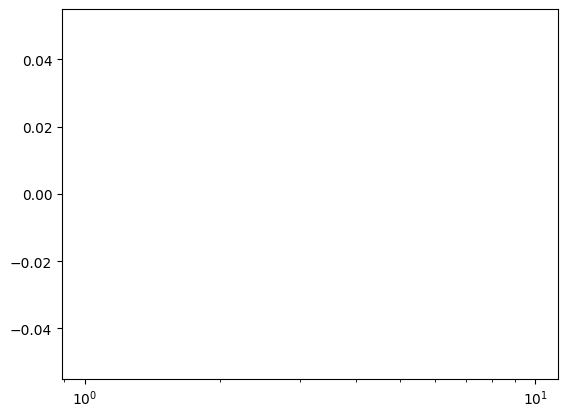

In [36]:
learn.lr_find()

In [138]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

x0 = b[0]
(xt, t), e = noisify(x0)
x0.shape

torch.Size([3, 64, 64])

In [116]:
xt.shape

torch.Size([1, 3, 64, 64])

In [118]:
n = len(x0.unsqueeze(0))
n

1

In [ ]:
t = torch.rand(n,).to(x0).clamp(0,0.999)
t.shape

In [140]:
def timestep_embedding(tsteps, emb_dim, max_period=10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

In [148]:
nfs = (224,448,672,896)
n_temb = nf = nfs[0]
n_emb = nf*4

In [155]:
t = torch.rand(1,).to(x0).clamp(0,0.999)
t.shape

torch.Size([1])

In [156]:
t_emb = timestep_embedding(t, nf)
t_emb.shape

torch.Size([1, 224])

In [157]:
emb_mlp = nn.Sequential(lin(n_temb, n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))
t_emb_mlp = emb_mlp(t_emb)
t_emb_mlp.shape

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 224])